In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# assume 2 objects first a disk and 2nd a double disk

# first circle has radius 1 and center at (0,0)
# second circle has radius 2 and center at (0,0)
# disk has radius 2  and center at (0,0)
# do sdf first for both.


# define sdf
def sdf(x, y, r):
    return np.sqrt(x**2 + y**2) - r

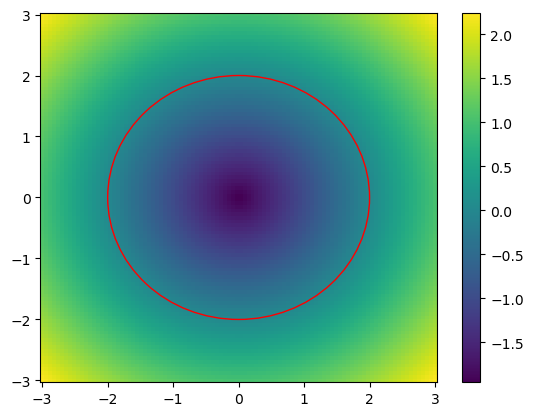

In [3]:
# ok do sdf for a circle
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
r = 2
Z = sdf(X, Y, r)

fig, ax = plt.subplots()
# add colorbar
c = ax.pcolormesh(X, Y, Z, cmap="viridis")
fig.colorbar(c, ax=ax)
# add the circle with radius r
circle = plt.Circle((0, 0), r, color="r", fill=False)
ax.add_artist(circle)
plt.show()
Z_1 = Z

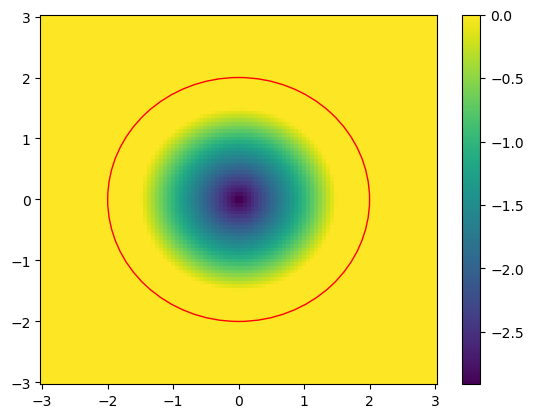

In [6]:
Z_diff = Z_1 - Z_2
fig, ax = plt.subplots()
# add colorbar
c = ax.pcolormesh(X, Y, Z_diff, cmap="viridis")
fig.colorbar(c, ax=ax)
# add the circle with radius r
circle = plt.Circle((0, 0), r, color="r", fill=False)
ax.add_artist(circle)
plt.show()

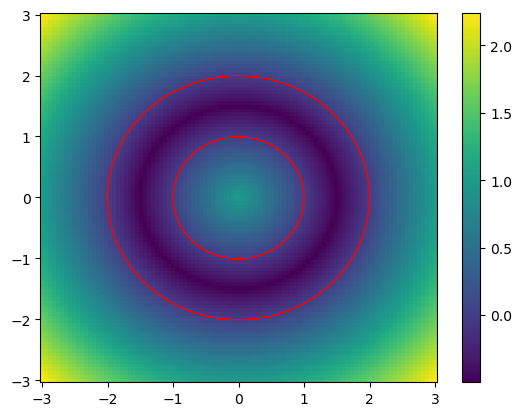

In [5]:
# ok now do sdf for a double disk
r1 = 1
r2 = 2
Z = np.maximum(-sdf(X, Y, r1), +sdf(X, Y, r2))

fig, ax = plt.subplots()
# add colorbar
c = ax.pcolormesh(X, Y, Z, cmap="viridis")
fig.colorbar(c, ax=ax)
# add the circle with radius r
circle = plt.Circle((0, 0), r1, color="r", fill=False)
ax.add_artist(circle)
circle = plt.Circle((0, 0), r2, color="r", fill=False)
ax.add_artist(circle)
plt.show()
Z_2 = Z

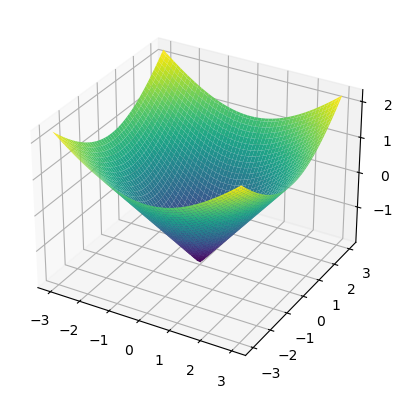

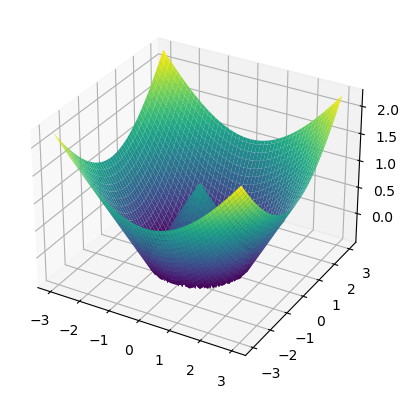

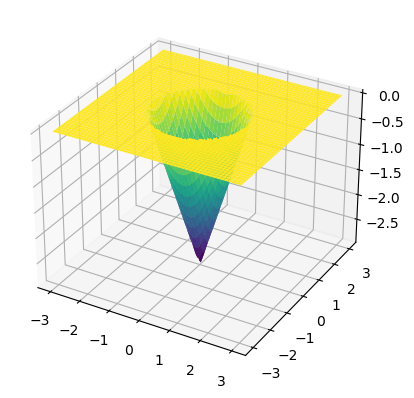

In [ ]:
# plot them as 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z_1, cmap="viridis")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z_2, cmap="viridis")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z_diff, cmap="viridis")
plt.show()

In [34]:
# lets define a different sdf (sqrt of integrading)
# L2 = sqrt(int_{2dspace} (sdf_1 - sdf_2)^2)
# lets define L@
def L2(sdf1, sdf2):
    return torch.sqrt(torch.sum((sdf1 - sdf2) ** 2))


# calc L2
sdf1 = torch.tensor(Z_1)
sdf2 = torch.tensor(Z_2)
print(L2(sdf1, sdf2))

tensor(53.7269, dtype=torch.float64)


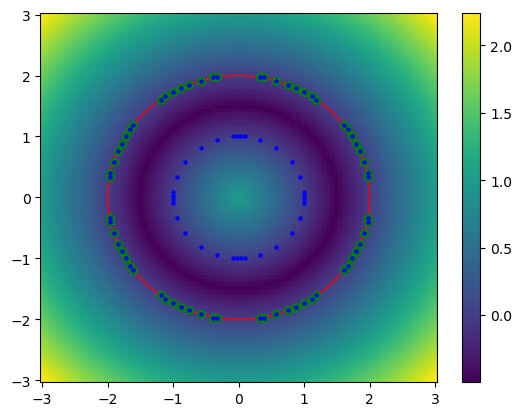

In [43]:
# ok now sample points in sdf_1 boundry
n = 100
# sample n1 points on sdf_1 boundry = (|sdf_1| < 0.01)
sdf1 = torch.tensor(Z_1)
sdf2 = torch.tensor(Z_2)
# masks
mask1 = torch.abs(sdf1) < 0.01
mask2 = torch.abs(sdf2) < 0.01
# sample points
x1 = X[mask1]
y1 = Y[mask1]
x2 = X[mask2]
y2 = Y[mask2]
# d(sdf_1, sdf_2) = sqrt(int_{over mask} sdf_1^2 + int_{over mask} sdf_2^2)
# lets calculate the integral using monte carlo integration
# do mean of the square of the values not the square of the mean
# calculate the integral
integral1 = torch.mean(sdf1[mask1] ** 2)
integral2 = torch.mean(sdf2[mask2] ** 2)

d = torch.sqrt(integral1 + integral2)
# lets plot masksed points
fig, ax = plt.subplots()
# add colorbar
c = ax.pcolormesh(X, Y, Z, cmap="viridis")
fig.colorbar(c, ax=ax)
# add the circle with radius r
circle = plt.Circle((0, 0), r, color="r", fill=False)
ax.add_artist(circle)
plt.scatter(x1, y1, c="g", s=30)
plt.scatter(x2, y2, c="b", s=5)
plt.show()

Epoch [0/500], Loss: 0.6836


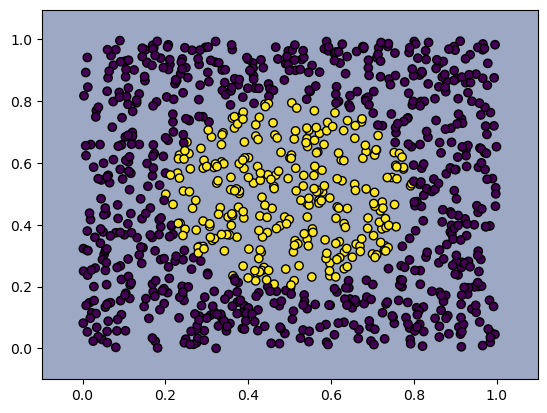

Epoch [100/500], Loss: 0.0435


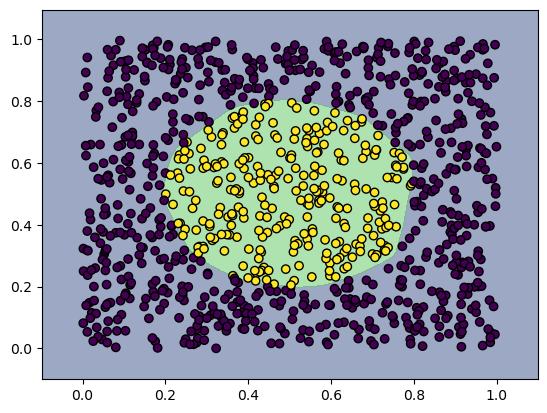

Epoch [200/500], Loss: 0.0208


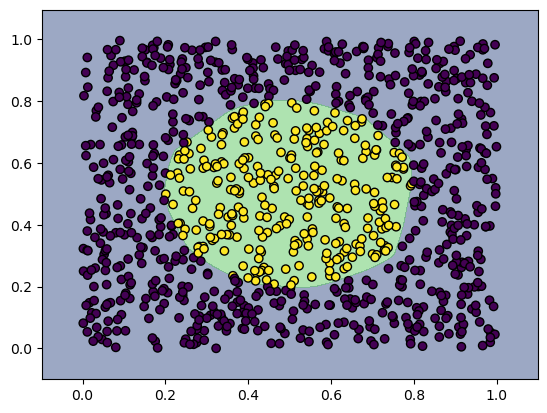

Epoch [300/500], Loss: 0.0139


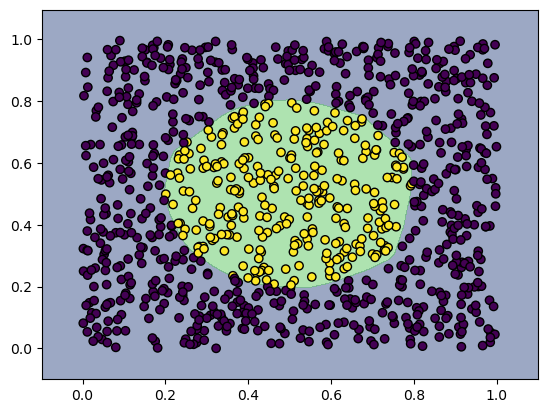

Epoch [400/500], Loss: 0.0112


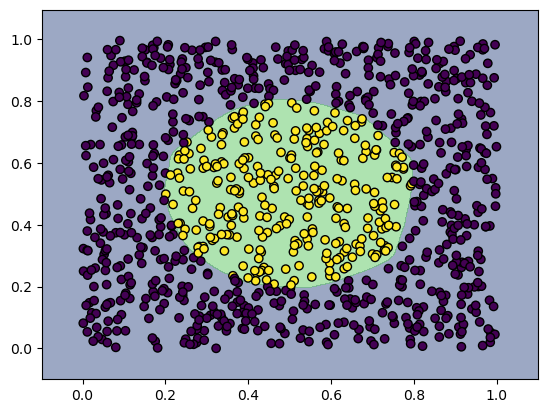

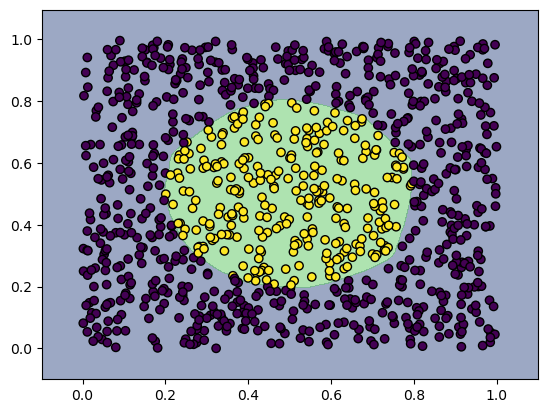

In [45]:
# create a simple obstacle problem
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# Define a simple neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 50),  # Input layer (x, y) coordinates
            nn.ReLU(),
            nn.Linear(50, 50),  # Hidden layer
            nn.ReLU(),
            nn.Linear(50, 1),  # Output layer, outputs distance to nearest obstacle
            nn.Sigmoid(),  # Sigmoid to ensure output is between 0 and 1
        )

    def forward(self, x):
        return self.fc(x)


# Initialize the network
net = SimpleNN()

# Example obstacle: Circle with center at (0.5, 0.5) and radius 0.3
obstacle_center = torch.tensor([0.5, 0.5])
obstacle_radius = 0.3


# Generate dummy data
def generate_data(n_samples=1000):
    points = torch.rand(n_samples, 2)  # Random points in [0, 1] x [0, 1]
    labels = torch.sqrt((points - obstacle_center).pow(2).sum(1)) - obstacle_radius
    labels = (labels < 0).float()  # 1 if inside the obstacle, 0 otherwise
    return points, labels


points, labels = generate_data()

# Training setup
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification problem
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = net(points).squeeze()  # Ensure output is of correct shape
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")
        # plot_decision_boundary(net, points.numpy(), labels.numpy())


# Plotting the decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    with torch.no_grad():
        Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
        Z = Z.view(xx.shape).numpy()

    plt.contourf(xx, yy, Z, alpha=0.5, levels=np.linspace(0, 1, 3))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
    plt.show()


plot_decision_boundary(net, points.numpy(), labels.numpy())